## VSBQ with the "two moons" example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from benchflow.utilities.cfg import cfg_to_task
from omegaconf import OmegaConf
from benchflow.plotting.utils import corner_plot

# Get the task object, which contains all the information about the task: log density function, parameter bounds, etc.
task_name = "bimodal"
task_cfg = OmegaConf.load(
    f"./benchflow/benchflow/config/task/{task_name}.yaml"
)

task = cfg_to_task(task_cfg)

Here we run multiple MAP optimization runs to find the mode of the task's posterior distribution. The runs will give us the log-density evaluations along the optimization traces.

In [3]:
%%capture
from benchflow.algorithms.generate_initial_set import (
    GenerateInitialSet,
    read_from_file,
)

algo_cfg = OmegaConf.load(
    "./benchflow/benchflow/config/algorithm/generate_initial_set.yaml"
)
N_samples = 1000
algo_cfg["method"] = "CMA-ES"
algo_cfg.map_optimization.stop_after_first = False
algo_cfg.map_optimization.N_fun_evals = N_samples
initial_points_path = (
    f"./data/initial_points/{task_name}/initial_train_set_{N_samples}.pkl"
)
algo_cfg["data_save_path"] = initial_points_path

try:
    data = read_from_file(initial_points_path)
    print("Loaded initial points from file")
except FileNotFoundError:
    print("Generating initial points")
    cfg = OmegaConf.create({"task": task_cfg, "algorithm": algo_cfg})
    data = GenerateInitialSet(cfg).run()

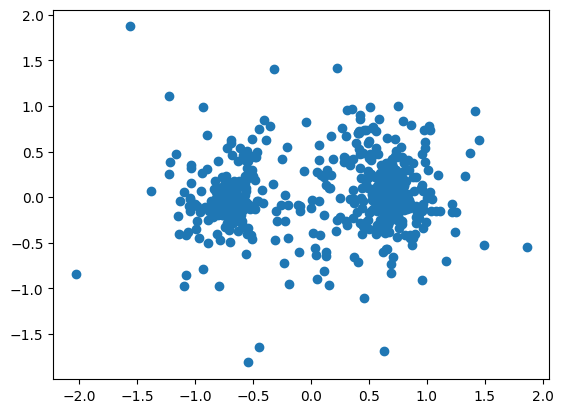

In [4]:
import matplotlib.pyplot as plt

plt.scatter(data["X"][:, 0], data["X"][:, 1]);

VSBQ now uses the trace points and their log-density values from the MAP optimizations to construct an approximate posterior.

In [5]:
from pyvbmc.vbmc.vbmc import VBMC

kwargs = {
    "x0": data["X"],
    "lower_bounds": task.lb,
    "upper_bounds": task.ub,
    "plausible_lower_bounds": task.plb,
    "plausible_upper_bounds": task.pub,
    "user_options": {
        "fvals": data["y"],
        "num_ips": 30,
        # See vsbq_bench.py for more comments on the clustering_init_hpdfrac and n_clusters hyperparameters
        "clustering_init_hpdfrac": 0.8,
        "n_clusters": 50,
    },
}
vbmc = VBMC(task.log_joint, **kwargs)

# Run VSBQ optimization
result = vbmc.optimize()

2024-06-17 18:21:33 Beginning variational optimization assuming EXACT observations of the log-joint.
2024-06-17 18:21:33  Iteration     Mean[ELBO]     Std[ELBO]     sKL-iter[q]   K[q]
2024-06-17 18:22:11      0             5.24          0.01          0.35       50  
2024-06-17 18:22:22      1             6.17          0.01          0.37       50  
2024-06-17 18:22:33      2             6.19          0.01          0.00       50  
2024-06-17 18:22:50      3             6.19          0.01          0.00       50  
2024-06-17 18:22:51 Inference terminated: reached maximum number of iterations options.maxiter.
2024-06-17 18:22:51 Estimated ELBO: 6.188 +/-0.010.
2024-06-17 18:22:51 Plotting final variational posterior...
2024-06-17 18:22:52 Plotting done. Saved to folder ./exp_example


Let's compare the approximate variational posterior with the ground truth posterior samples.

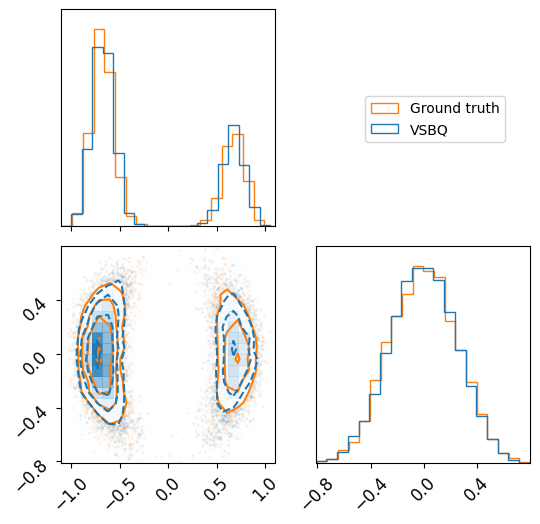

In [6]:
vp = result[0]  # the variational posterior
samples = vp.sample(10000, origflag=True)[0]
gt_samples = task.get_posterior_samples(10000)
corner_plot(gt_samples, samples);